# <font  color = "#0093AF">NOVEL</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter4/Ch4_NOVEL.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Nuclear Overhauser effect Via Electron spin-Locking (NOVEL)$^1$ is a DNP transfer mechanism which occurs by matching a spin-lock applied to electrons to the nuclear Larmor frequency. The sequence needs to be repeated many times to build up bulk nuclear polarization. Here we set up the transfer, and investigate some simple improvements to make the transfer more efficient.

[1] A. Henstra, P. Dirksen, J. Schmidt, W.Th. Wenckebach. [*J. Magn. Reson.*](https://doi.org/10.1016/0022-2364(88)90190-4), **1988**, 77, 389-393.

## Setup

In [213]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system

We build an electron-nuclear system, noting that the nucleus needs to be in the lab frame, since the pseudosecular hyperfine coupling drives NOVEL transfer. We start monitoring magnetization during the NOVEL sequence (a $pi/2$-pulse followed by a spin-lock).

<AxesSubplot:xlabel='t / $\\mu$s', ylabel='<Op>'>

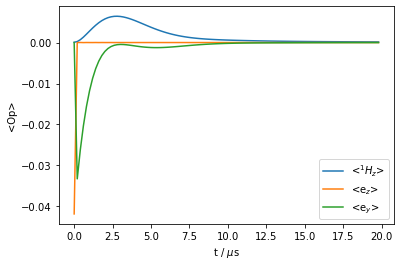

In [214]:
ex=sl.ExpSys(v0H=212,Nucs=['1H','e'],vr=0,LF=[True,False],T_K=80,pwdavg=2)
delta=4e5
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=ex.Liouvillian()

# Note that because the nuclear quantization axis is tilted away from z, 
# it is important to set OS=True
L.add_relax(Type='T2',i=0,T2=5e-3,OS=True)
L.add_relax(Type='T2',i=1,T2=.890e-6,OS=True)
L.add_relax(Type='T1',i=0,T1=13.7,OS=True,Thermal=True)
L.add_relax(Type='T1',i=1,T1=1.4e-3,OS=True,Thermal=True)

v1=212e6
pi2=1/v1/4
SL=2e-5

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL],v1=[v1,v1],phase=[0,np.pi/2])

rho=sl.Rho('Thermal',['1Hz','ez','ey'])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.plot(axis='us')

We monitor electron *z*- and *y*-magnetization, where an initial $\pi$/2-pulse on the electron converts all electron *z*-magnetization to *y*-magnetization. That magnetization is then transferred to the nucleus. However, it also decays primarily due to the electron $T_2$ relaxation. Then, we see that the length of the transfer could be optimized to minimize this loss, by setting the transfer time near to where the maximum nuclear polarization occurs. We add a recycle delay (`RD`) to see what happens to the magnetization after the transfer.

### Stop transfer after maximum reached

<AxesSubplot:xlabel='t / $\\mu$s', ylabel='<Op>'>

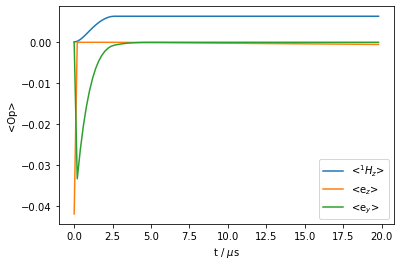

In [215]:
SL=2.5e-6
RD=2e-5

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])

rho=sl.Rho('Thermal',['1Hz','ez','ey'])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.plot(axis='us')

In [216]:
print(f'Enhancement: {rho.I[0].real.max()/ex.Peq[0]:.0f}')

Enhancement: 100


In this case, the nuclear magnetization stays at its maximum by turning off the spin-lock after the maximum is reached. Little changes on the magnetization otherwise, except a small amount of electron $T_1$ recovery.

While the nucleus is enhanced, we wonder if it is possible to achieve a higher enhancement with repeated transfers. Then, we need to include a delay between repeated sequences. First we try to set the recycle delay to the electron $T_1$.

### Recycle the sequence

<AxesSubplot:xlabel='t / ms', ylabel='<Op>'>

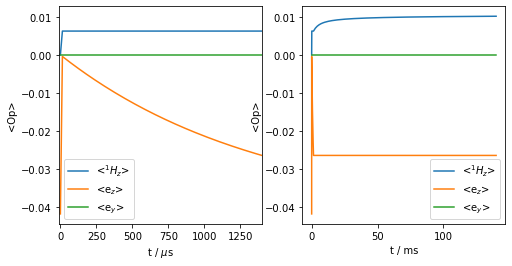

In [217]:
SL=0.25e-5
RD=1.4e-3

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])

rho=sl.Rho('Thermal',['1Hz','ez','ey'])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.DetProp(seq,n=100)

ax=plt.subplots(1,2,figsize=[8,4])[1]
rho.plot(axis='us',ax=ax[0])
ax[0].set_xlim([-10,1400])
rho.plot(axis='ms',ax=ax[1])

In [218]:
print(f'Enhancement: {rho.I[0].real.max()/ex.Peq[0]:.0f}')

Enhancement: 161


We increase the enhancement, but still not to the theoretical max of 657. We notice that the electron z-magnetization equilibrates at a fraction of its original polarization. One option to improve the enhancement is to increase the recycle delay to give the electron more chance to recover. Here, we take 5*$T_1$ to obtain nearly fully recovery.

### Use longer relaxation delay (5*$T_{1e}$)

<AxesSubplot:xlabel='t / ms', ylabel='<Op>'>

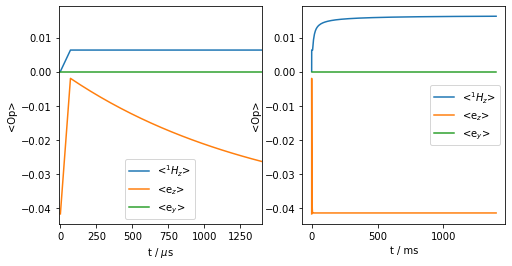

In [219]:
SL=0.25e-5
RD=1.4e-3*5

seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])

rho=sl.Rho('Thermal',['1Hz','ez','ey'])
rho.DetProp(seq,n=100,n_per_seq=100)
rho.DetProp(seq,n=200)

ax=plt.subplots(1,2,figsize=[8,4])[1]
rho.plot(axis='us',ax=ax[0])
ax[0].set_xlim([-10,1400])
rho.plot(axis='ms',ax=ax[1])

In [220]:
print(f'Enhancement: {rho.I[0].real.max()/ex.Peq[0]:.0f}')

Enhancement: 256


### Optimize relaxation delay for fast-relaxing nuclei

The improvement is far more pronounced. Since the electron recovers full after every step, much more electron polarization is available to transfer to the nucleus. In our example here, the nuclear $T_1$ is about 1000 times longer than that of the electron, so there isn't really any compromise on the recycle delay between the electron recovering and the nucleus losing magnetization. However, in a real system, losses on the nuclei are much more pronounced, because the magnetization spreads among many protons. Let's mimick this by shortening the nuclear T1 by a factor of 500 (if spread of polarization among the nuclei were infinitely fast, the rate of magnetization loss would be enhanced by the number of nuclei). Then, we optimize the recycle delay for this situation. 

Since this optimization takes some time, we go to a single crystallite. Note that if the hyperfine coupling is aligned along the *z*-axis or the *xy*-plane, the pseudosecular coupling will vanish, eliminating the NOVEL transfer. Therefore, we use the 'alpha0beta45' powder average, which just has one set of Euler angles ($\alpha=0^\circ$, $\beta=45^\circ$, $\gamma=0^\circ$)

To get the true optimimum, we would need to include the powder average, but for sake of example, this is sufficient.

In [221]:
ex=sl.ExpSys(v0H=212,Nucs=['1H','e'],vr=0,LF=[True,False],T_K=80,pwdavg='alpha0beta45')
delta=4e5
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=ex.Liouvillian()

L.add_relax(Type='T2',i=0,T2=5e-3,OS=True)
L.add_relax(Type='T2',i=1,T2=.890e-6,OS=True)
L.add_relax(Type='T1',i=0,T1=13.7/500,OS=True,Thermal=True)
L.add_relax(Type='T1',i=1,T1=1.4e-3,OS=True,Thermal=True)

v1=212e6
pi2=1/v1/4
SL=0.25e-5
rho=sl.Rho('Thermal','1Hz')

RD0=np.linspace(0.5,5,50)*1.4e-3
e=[]

for RD in RD0:
    seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])
    rho.clear()
    #A sequence or propagator raised to infinity finds the equilibrium density matrix
    (seq**np.inf*rho)()
    e.append(rho.I[0][0].real/ex.Peq[0])

Text(0, 0.5, 'Enhancement')

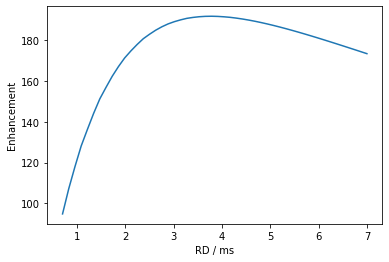

In [222]:
ax=plt.subplots()[1]
ax.plot(RD0*1e3,e)
ax.set_xlabel('RD / ms')
ax.set_ylabel('Enhancement')

In [223]:
i=np.argmax(e)
print(f'Maximum enhancement of {e[i]:.0f} at RD={RD0[i]*1e3:.1f} ms')

Maximum enhancement of 192 at RD=3.8 ms


### Re-optimize spin-lock length

We return now to the longer nuclear $T_1$. A remaining question is: why can't we actually achieve the full theoretical enhancement of 657, if the nuclear relaxation is so slow? 

The problem is that the while for one repetition of the NOVEL sequence, the optimal $^1H$ polarization occured at about 2.5 μs. However, significant electron polarization loss has already occured for a spin-lock of that length, given the $T_2$ of 0.89 μs (note under the spin-lock, the effective $T_{1\rho}$ becomes twice the set value of $T_2$). So, we can also optimize the spin-lock length (using 5*$T_1$ for the recycle delay).

In [225]:
ex=sl.ExpSys(v0H=212,Nucs=['1H','e'],vr=0,LF=[True,False],T_K=80,pwdavg='alpha0beta45')
delta=4e5
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)

L=ex.Liouvillian()

L.add_relax(Type='T2',i=0,T2=5e-3,OS=True)
L.add_relax(Type='T2',i=1,T2=.890e-6,OS=True)
L.add_relax(Type='T1',i=0,T1=13.7,OS=True,Thermal=True)
L.add_relax(Type='T1',i=1,T1=1.4e-3,OS=True,Thermal=True)

v1=212e6
pi2=1/v1/4
SL=0.25e-5
RD=5*1.4e-3
rho=sl.Rho('Thermal','1Hz')

SL0=np.linspace(0,2.5e-6,200)
e=[]

for SL in SL0:
    seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])
    rho.clear()
    #A sequence or propagator raised to infinity finds the equilibrium density matrix
    (seq**np.inf*rho)()
    e.append(rho.I[0][0].real/ex.Peq[0])

Text(0, 0.5, 'Enhancement')

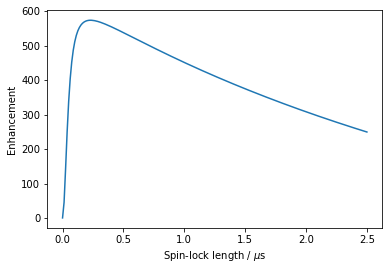

In [226]:
ax=plt.subplots()[1]
ax.plot(SL0*1e6,e)
ax.set_xlabel('Spin-lock length / $\mu$s')
ax.set_ylabel('Enhancement')

In [227]:
i=np.argmax(e)
print(f'Maximum enhancement of {e[i]:.0f} at SL={SL0[i]*1e6:.2f} μs')

Maximum enhancement of 574 at SL=0.23 μs


Finally, we are close to the maximum enhancement. We plot the buildup of that polarization below

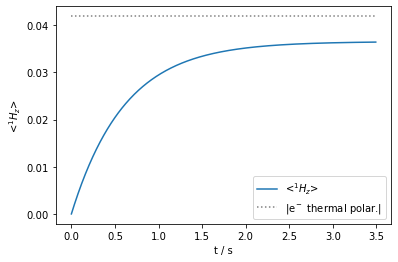

In [229]:
SL=SL0[i]
seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])
rho.clear()
rho.DetProp(seq,n=500)
ax=rho.plot(axis='s')
ax.plot([0,rho.t_axis[-1]],-np.ones(2)*ex.Peq[1],color='grey',linestyle=':',label=r'|e$^-$ thermal polar.|')
ax.legend()

In [230]:
i=np.argmax(rho.I[0]/rho.I[0][-1]>0.95)
print(f'Maximum enhancement of {rho.I[0][-1].real/ex.Peq[0]:.0f}, 95% of max reached at {rho.t_axis[i]:.2f} s')

Maximum enhancement of 572, 95% of max reached at 1.79 s


### Buildup with varying spin-lock length

While the enhancement is optimized, the buildup is quite slow. A shorter spin-lock is required to achieve the maximum enhancement, but this makes a very inefficient buildup at the beginning of the sequence, where we saw at the beginning of this section that the maximum enhancement came much later, at 2.5 μs. Here, we see what happens if we vary the spin-lock length, from long to short (2.5 μs to 0.2 μs), during the buildup.

In [231]:
rho=sl.Rho('Thermal','1Hz')

SL0=0.2e-6+np.exp(-np.linspace(0,1,100)*20)*(2.5e-6-0.2e-6)

for SL in SL0:
    seq=L.Sequence().add_channel('e',t=[0,pi2,pi2+SL,RD],v1=[v1,v1,0],phase=[0,np.pi/2,0])
    #A sequence or propagator raised to infinity finds the equilibrium density matrix
    seq**5*rho()  #Makes a total of 500*RD

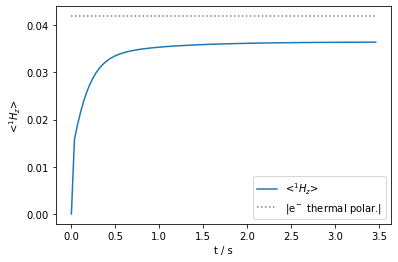

In [232]:
ax=rho.plot(axis='s')
ax.plot([0,rho.t_axis[-1]],-np.ones(2)*ex.Peq[1],color='grey',linestyle=':',label=r'|e$^-$ thermal polar.|')
ax.legend()

In [233]:
i=np.argmax(rho.I[0]/rho.I[0][-1]>0.95)
print(f'Maximum enhancement of {rho.I[0][-1].real/ex.Peq[0]:.0f}, 95% of max reached at {rho.t_axis[i]:.2f} s')

Maximum enhancement of 572, 95% of max reached at 0.70 s


Above, we've caused the spin-lock length to start at 2.5 μs and end at 0.2 μs, where a decaying exponential defines the transition between the two values (the time constant of this decay has been optimized by hand, the choice of an exponential is only a guess). As we see 95% of the maximum enhancement is reached much more quickly than with a fixed spin-lock length.